Based on ds_tree.ipynb

This is the data structure based on the theory section of the thesis, which tries to be as minimal as possible.
We then have:
- constructor functions that can build this data structure. E.g:
    - random networks
    - sympy equation builder
    - manual solver structure builder
- mapping functions that can associate additional information with each datastructure. E.g:
    - openMDAO namer(or any other renamer)
    - mapping to actualy functions(that need to have the correct data shape for input and output)
- processing functions that extract useful information based on the datastructures. E.g:
    - returning all variables
    - get input variables
    - get output variables

# Example data structure
## Directed Graph

In [1]:
from collections import OrderedDict, defaultdict, namedtuple
from functools import partial
import itertools
import networkx as nx
from representations import draw
from itertools import chain
from enum import Enum
from copy import copy
import numpy as np

In [2]:
NodeTypes = Enum('NodeTypes', 'VAR COMP SOLVER')
VAR, COMP, SOLVER = NodeTypes.VAR,NodeTypes.COMP,NodeTypes.SOLVER

In [3]:
nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: 's_{}'}
Node = namedtuple('NODE', ['name', 'nodetype'])
Node.__repr__ = lambda x: nodetyperepr[x.nodetype].format(x.name)
Node.__str__ = Node.__repr__

In [4]:
Ein = {
    1: (7,),
    2: (3,6),
    3: (1,),
    4: (2,4),
    5: (3,2)
}
# IMPORTANT: Need to enforce that each output variable 
# can only be connected to one function
Eout = {
    1: (6,),
    2: (1,),
    3: (2,), 
    4: (None,), # this gives us the size of the outputs
    5: (5,), # Use None to indicate the size of the output
}

Rin = {
    #3: (2,) # in original model its 3: (2,), so we have x_2 = f3(x_1)
}

In [5]:
def filter_comps(E, filterto=None):
    return ((key,val) for key,val in E.items() if not filterto or key in filterto)

In [49]:
def transform_E(E, tfx=None, tvar=None):
    tfx = tfx if tfx else lambda fx: fx
    tvar = tvar if tvar else lambda var: var
    return {tfx(fx): tuple(tvar(var) if var!=None else None for var in vrs) for fx, vrs in E.items()} 
def edges_E(E, reverse=True, transform=None, filterto=None):
    E = dict(filter_comps(E, filterto))
    E = transform(E) if transform else E
    return [(var,fx) if reverse else (fx,var) for fx,vrs in E.items() for var in vrs if var]
def all_edges(Ein, Eout, transform=None, filterto=None):
    return edges_E(Ein, True, transform, filterto)+edges_E(Eout, False, transform, filterto)

In [7]:
def merge_edges(Ein, Rin):
    return {key: var+Rin.get(key, tuple()) for key,var in Ein.items()}

# Processing functions

In [8]:
def all_components(E):
    return set(E.keys())

In [9]:
def end_components(E):
    return [key for key,var in E.items() if None in var]

In [10]:
def all_varnodes(E, filterto=None):
    return {var for key,val in filter_comps(E, filterto) for var in val}

In [11]:
def all_variables(Ein, Eout, filterto=None):
    return all_varnodes(Ein, filterto).union(all_varnodes(Eout, filterto)-{None})

In [12]:
def sources(Ein, Eout, filterto=None):
    return all_varnodes(Ein, filterto)-all_varnodes(Eout, filterto)

In [13]:
def sinks(Ein, Eout, filterto=None):
    return all_varnodes(Eout, filterto)-all_varnodes(Ein, filterto)

In [14]:
all_variables(Ein, Eout)

{1, 2, 3, 4, 5, 6, 7}

In [15]:
sources(Ein, Eout)

{3, 4, 7}

# Typed graph

## Flat graph
This is the flat graph that doesn't use any information about the tree

In [16]:
edges = all_edges(merge_edges(Ein,Rin), Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))

In [17]:
G = nx.DiGraph(edges)

In [18]:
var_names = [Node(var, VAR) for var in all_variables(Ein, Eout)]

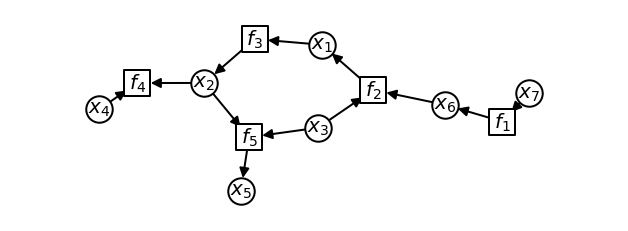

In [19]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

## Ordered tree

In [20]:
Stree = {
    2:1
}
Ftree = OrderedDict((
    (1,1),
    (2,2),
    (3,2),
    (4,2),
    (5,1)
))
Vtree = {
    3:2
}

## Functions

In [21]:
Ein = {
    1: (7,),
    2: (3,6),
    3: (1,),
    4: (2,4),
    5: (3,2)
}
# IMPORTANT: Need to enforce that each output variable 
# can only be connected to one function
Eout = {
    1: (6,),
    2: (1,),
    3: (2,), 
    4: (None,), # this gives us the size of the outputs
    5: (5,), # Use None to indicate the size of the output
}

Rin = {
    #3: (2,) # in original model its 3: (2,), so we have x_2 = f3(x_1)
}

In [22]:
# lookup table for functions
f = {
    ((6,),(7,)): lambda x,y: (x+y,),
    ((1,),(3,6)): lambda x,y,z: (x+y+z,),
    ((2,),(1,)): lambda x: x**2,
    ((None,),(2,4)): lambda x,y: (x+y,),
    ((5,),(3,2)): lambda x,y,z: (x+y,)
}

# Generating workflows

## Merging

In [35]:
merge_comps = {2,3,4}

Need to operate on graphs

In [36]:
def get_edges(G):
    Ein, Eout = dict(), dict()
    for node in filter(lambda x: x.nodetype!=VAR, G.nodes()):
        Ein[node] = set(G.predecessors(node))
        Eout[node] = set(G.successors(node))
    return Ein, Eout

In [369]:
def merge_graph(G, typed_mergelts, solve_vars, solver_idx=0):
    graph_Ein, graph_Eout = get_edges(G)
    typed_nonmergelts = {elt for elt in G.nodes() if elt.nodetype!=VAR and elt not in typed_mergelts}
    graph_Ein_merge = dict(filter_comps(graph_Ein, typed_mergelts))
    graph_Eout_merge= dict(filter_comps(graph_Eout, typed_mergelts))
    
    # Merge children components
    child_edges = all_edges(graph_Ein_merge, graph_Eout_merge)
    G_child = nx.DiGraph(child_edges)
    
    # Update parent components
    typed_solve_vars = {Node(var, VAR) for var in solve_vars}
    srcs = sources(graph_Ein_merge, graph_Eout_merge)
    allowable_solvevars = srcs.intersection(sources(graph_Ein,graph_Eout))
    assert all(var in allowable_solvevars for var in typed_solve_vars)
    mergecomp_ins = srcs-typed_solve_vars
    mergecomp_outs = all_varnodes(graph_Eout_merge).intersection(
        all_varnodes(graph_Ein, typed_nonmergelts)).union(typed_solve_vars)
    new_Ein = chain(
        filter_comps(graph_Ein, filterto=typed_nonmergelts),
        ((Node(solver_idx, SOLVER), mergecomp_ins),)
    )
    new_Eout = chain(
        filter_comps(graph_Eout, filterto=typed_nonmergelts), 
        ((Node(solver_idx, SOLVER),mergecomp_outs),)
    )
    parent_edges=all_edges(dict(new_Ein), dict(new_Eout))
    G_parent = nx.DiGraph(parent_edges)
    return G_parent, G_child

In [38]:
G_parent, G_child = merge_graph(G, {Node(2,COMP),Node(3,COMP)}, {3}, solver_idx=1)

In [39]:
G_parent2, G_child2 = merge_graph(G_parent, {Node(4,COMP),Node(5,COMP), Node(1,COMP)}, {}, solver_idx=2)

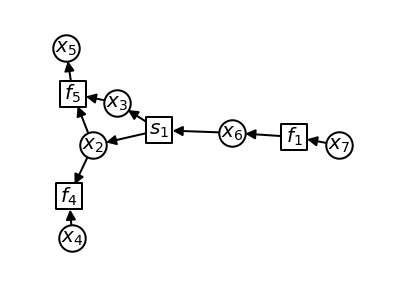

In [40]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G_parent.nodes()}
draw(G_parent, node_shape=node_shapes, prog='sfdp',figsize=(7,5), latexlabels=False);

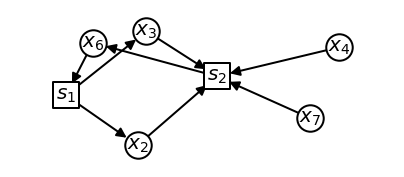

In [41]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G_parent2.nodes()}
draw(G_parent2, node_shape=node_shapes, prog='sfdp',figsize=(7,3), latexlabels=False);

# Build graphs

In [23]:
tree = {
    2:1,
}

In [24]:
def level_order_tree(tree, root=1):
    level_order = [root]
    next_dict = defaultdict(list)
    for key,val in tree.items():
        next_dict[val].append(key) 
    q = [root]
    while q:
        idx = q.pop()
        elts = next_dict[idx]
        level_order+=elts
        q+=elts
    return level_order

In [25]:
level_order_tree(tree)

[1, 2]

In [43]:
def solver_children(tree, solver_idx):
    return {comp for comp,parent_solver in tree.items() if parent_solver==solver_idx}

In [44]:
solver_children(Stree, 1)

{2}

In [67]:
def build_typedgraph(G, Ftree, Stree, Vtree):
    graphs = dict()
    G_parent = G
    merge_order = level_order_tree(Stree)[::-1]
    for solver_idx in merge_order:
        merge_comps = {Node(comp, COMP) for comp in solver_children(Ftree, solver_idx)}.union(
                    {Node(solver, SOLVER) for solver in solver_children(Stree, solver_idx)})
        solve_vars = {var for var in solver_children(Vtree, solver_idx)}
        G_parent, graphs[solver_idx] = merge_graph(G_parent, merge_comps, solve_vars, solver_idx)
    return graphs

In [ ]:
graphs = build_typedgraph(G)

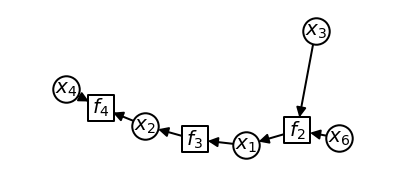

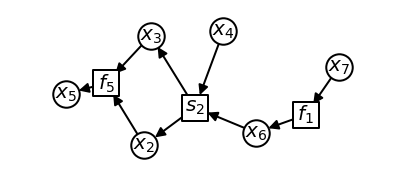

In [46]:
for key,graph in graphs.items():
    node_shapes = {elt:'o' if elt in var_names else 's' for elt in graph.nodes()}
    draw(graph, node_shape=node_shapes, prog='sfdp',figsize=(7,3), latexlabels=False);

# Operations

In [47]:
def copy_dicts(dicts):
    return tuple(dict(d) for d in dicts)

### standardize

In [387]:
def standardize_comp(edges, Vtree, Ftree, comp, vrs=None):
    Ein, Eout, Rin = copy_dicts(edges)
    if vrs:
        updated_outs = tuple(elt for elt in Eout[comp] if elt not in vrs)
    else:
        vrs, updated_outs = zip(*((elt,None) for elt in Eout[comp])) 
    Eout[comp] = updated_outs
    Rin[comp] = vrs
    Vtree = dict(Vtree)
    parent = Ftree[comp]
    Vtree.update({vr:parent for vr in vrs})
    return (Ein, Eout, Rin), Vtree

In [49]:
Ein = {
    1: (2,),
    2: (1,),
}
Eout = {
    1: (1,),
    2: (2,)
}
Rin = {
}
Vtree=dict()
Ftree=OrderedDict(((1,1),(2,1)))

In [50]:
edges = (Ein, Eout, Rin)
tree = (Vtree, Ftree)
edges, Vtree = standardize_comp(edges, Vtree, Ftree, 1)
edges, Vtree = standardize_comp(edges, Vtree, Ftree, 2)

In [52]:
stEin = merge_edges(edges[0], edges[2])
stEout = edges[1]
Gedges = all_edges(Ein, Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))

In [53]:
G = nx.DiGraph(Gedges)

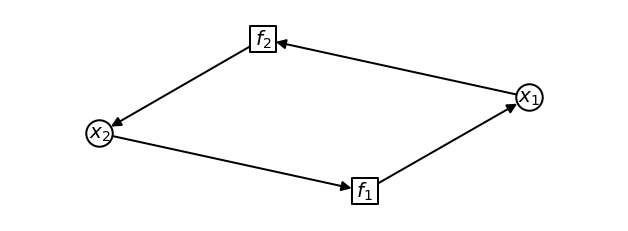

In [54]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

For solver we should just unmerge it (assumed that it is acyclic)

In [55]:
def standardize_solver(tree, solver_idx):
    Ftree, Stree = copy_dicts(tree)
    parent_solver = Stree[solver_idx]
    comp_children = solver_children(Ftree, solver_idx)
    for comp in comp_children:
        Ftree[comp] = parent_solver
    subsolvers = solver_children(Stree, solver_idx)
    for subsolver in subsolvers:
        Stree[subsolver] = parent_solver
    Stree.pop(solver_idx)
    return Ftree, Stree

In [56]:
Ein = {
    1: (1,2),
    2: (2,1,3),
    3: (2,),
}
Eout = {
    1: (None,),
    2: (None,),
    3: (3,)
}
Rin = {
}
Vtree=dict()
Ftree=OrderedDict(((1,2),(2,2),(3,1)))
Stree={2:1}

In [57]:
standardize_solver((Ftree, Stree), 2)

({1: 1, 2: 1, 3: 1}, {})

# Make acyclic

This operates on the DiGraph with class nodes structure

In [58]:
def sort_scc(G, filterfx):
    C = nx.condensation(G)
    order = []
    for n in nx.topological_sort(C):
        filtereqs = {elt for elt in C.nodes[n]['members'] if filterfx(elt)}
        if filtereqs:
            order.append(filtereqs)
    return order

In [ ]:
newStree = dict(Stree)
newFtree = OrderedDict()
newVtree = dict(

In [434]:
Ein = {
    1: (2,),
    2: (1,),
    3: (2,3),
}
Eout = {
    1: (1,),
    2: (2,),
    3: (None,)
}
Rin = {
}
Vtree={3:1}
Ftree=OrderedDict(((1,1),(2,1),(3,1)))
Stree=dict()

In [435]:
Gedges = all_edges(merge_edges(Ein, Rin), Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))
G = nx.DiGraph(Gedges)

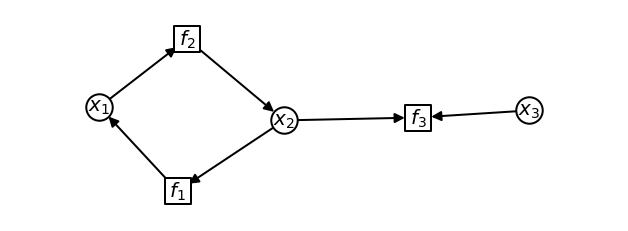

In [436]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

In [437]:
#graphs = build_typedgraph(G, Ftree, Stree, Vtree)
# for key,graph in graphs.items():
#     node_shapes = {elt:'o' if elt in var_names else 's' for elt in graph.nodes()}
#     draw(graph, node_shape=node_shapes, prog='sfdp',figsize=(7,3), latexlabels=False);

In [438]:
edges = Ein, Eout, Rin
tree = Ftree,Stree,Vtree

In [439]:
def merge_and_standardize(edges, tree, mergecomps, parentidx=1, newidx=2):
    Ftree, Stree, Vtree = tree
    Ftree = OrderedDict(Ftree)
    Stree = dict(Stree)
    Stree[newidx]=parentidx
    for node in mergecomps:
        if node.nodetype == COMP:
            assert Ftree[node.name] == parentidx # can only merge nodes at the same level
            Ftree[node.name] = newidx
            edges, Vtree = standardize_comp(edges, Vtree, Ftree, 
                                            node.name, vrs=None)
        else:
            assert Stree[node.name] == parentidx
            # we remove the solver and raise all children one level up
            Ftree, Stree = standardize_solver(Ftree, Stree, node.name)
    return edges, (Ftree, Stree, Vtree)

In [440]:
edges, tree

(({1: (2,), 2: (1,), 3: (2, 3)}, {1: (1,), 2: (2,), 3: (None,)}, {}),
 (OrderedDict([(1, 1), (2, 1), (3, 1)]), {}, {3: 1}))

In [441]:
nedges, ntree = merge_and_standardize(edges, tree, {Node(1,COMP),Node(2,COMP)}, 1, 2)

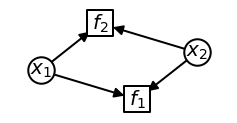

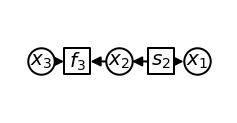

In [442]:
Gedges = all_edges(merge_edges(nedges[0], nedges[2]), nedges[1], partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))
G = nx.DiGraph(Gedges)
graphs = build_typedgraph(G, *ntree)
for key,graph in graphs.items():
    node_shapes = {elt:'o' if elt in var_names else 's' for elt in graph.nodes()}
    draw(graph, node_shape=node_shapes, prog='sfdp',figsize=(4,2), latexlabels=False);

In [443]:
scc = [{Node(1,COMP),Node(2,COMP)},{Node(3,COMP)}]

In [444]:
def reorder_merge_solve(edges, tree, merge_order, solver_idx, mdf=True):
    tree = tuple((dict(d) if idx !=0 else OrderedDict(d)) for idx, d in enumerate(tree))
    nFtree = OrderedDict()
    for connected_components in scc:
        if len(connected_components) > 1:
            new_idx = max(chain(Stree.keys(),(1,)))+1
            edges, tree = merge_and_standardize(edges, tree, connected_components, solver_idx, new_idx)
        Ftree = tree[0]
        for node in connected_components:
                if node.nodetype == COMP:
                    nFtree[node.name] = Ftree[node.name]
    return edges, (nFtree, ntree[1], ntree[2])

In [445]:
edges, tree

(({1: (2,), 2: (1,), 3: (2, 3)}, {1: (1,), 2: (2,), 3: (None,)}, {}),
 (OrderedDict([(1, 1), (2, 1), (3, 1)]), {}, {3: 1}))

In [446]:
nedges, ntree = reorder_merge_solve(edges, tree, scc, solver_idx)

In [447]:
nedges, ntree

(({1: (2,), 2: (1,), 3: (2, 3)},
  {1: (None,), 2: (None,), 3: (None,)},
  {2: (2,), 1: (1,)}),
 (OrderedDict([(2, 2), (1, 2), (3, 1)]), {2: 1}, {3: 1, 2: 2, 1: 2}))

In [448]:
ntree[0].keys()

odict_keys([2, 1, 3])

In [449]:
stEin = merge_edges(nedges[0], nedges[2])
stEout = nedges[1]
Gedges = all_edges(stEin, stEout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))

In [450]:
G = nx.DiGraph(Gedges)

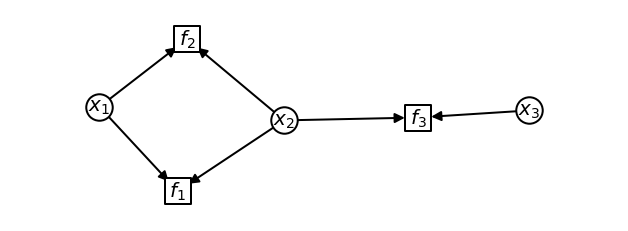

In [451]:
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='sfdp', figsize=(11,4), latexlabels=False);

# Workflow generation based on tree

In [452]:
Vtree=dict()
Ftree=OrderedDict(((1,2),(2,2),(3,1)))
Stree={2:1, 3:2, 4:3}

In [453]:
def path(Stree, s, visited=None):
    visited = visited if visited else set()
    out = []
    q = {s} if s in chain(Stree.values(),Stree.keys()) else set()
    while q:
        s = q.pop()
        if s not in visited:
            out.append(s)
            if s in Stree:
                q.add(Stree[s])
        visited.add(s)
    return out

In [454]:
path(Stree, 4, visited={3})

[4]

In [455]:
nedges

({1: (2,), 2: (1,), 3: (2, 3)},
 {1: (None,), 2: (None,), 3: (None,)},
 {2: (2,), 1: (1,)})

In [456]:
Fend = end_components(nedges[1])

In [457]:
def generate_workflow(Ftree, Stree, Vtree):
    visited = set()
    workflow = []
    for key,parentsolver in Ftree.items():
        out = path(Stree, parentsolver, visited)
        visited = visited.union(out) 
        workflow.extend([("solver", s, Stree.get(s, None), solver_children(Vtree, s), solver_children({F:Ftree[F] for F in Fend}, s)) for s in out[::-1]])
        workflow.append(("exec", key, parentsolver))
    return workflow

In [458]:
generate_workflow(*ntree)

[('solver', 1, None, {3}, {3}),
 ('solver', 2, 1, {1, 2}, {1, 2}),
 ('exec', 2, 2),
 ('exec', 1, 2),
 ('exec', 3, 1)]

# Simplifications

Solver simplification and residual simplification can be merged under one idea

This allows to override the solver creation, and instead replace the execs that would fall underneath with one function

In [22]:
# The idea is that it replaces any solvers it sees with the following inputs and outputs with a new exec with the following function:
sargmap = {
    ((2,3),(1,2)): lambda x,y: (x+y,x*y), #for a solver for example
    ((1,2),(None,)): lambda x,y: y-f[((1,),(2,))](x) # for a residualized example, for elements in Rin
}

In [25]:
sargmap[((1,2),(None,))](5,4)

-21

## Automatic generation of residual functions
Should also work with multivariable residuals

In [199]:
Ein = {
    1: (2,),
    2: (1,),
}
Eout = {
    1: (None,),
    2: (None,),
}
Rin = {
    1: (1,),
    2: (2,),
}

In [137]:
f = {
    ((1,),(2,)): lambda x: x**2,
    ((2,),(1,)): lambda x: x+200
}

In [192]:
def bindFunction(function, n_reversed):
    def residual(*x):
        return np.array(x[n_reversed:])-function(*x[0:n_reversed]) 
    return residual

In [193]:
def generate_residuals(Ein, Rin, f):
    residuals = dict()
    merged_edges = merge_edges(Ein,Rin) # this makes sure we get the same order as used during workflow generation
    for fx,ins in Rin.items():
        merged_ins = merged_edges[fx]
        fkey = (Rin[fx], Ein[fx]) #Rin encodes the old outputs
        function = f[fkey]
        n_reversed = len(ins)
        output_size = (None,)*n_reversed
        # need to do some local binding for residual function
        residuals[(merged_ins, output_size)] = bindFunction(function, n_reversed)
    return residuals

In [194]:
residuals = generate_residuals(Ein, Rin, f)

In [200]:
residuals

{((1, 2), (None,)): <function __main__.bindFunction.<locals>.residual(*x)>,
 ((2, 1), (None,)): <function __main__.bindFunction.<locals>.residual(*x)>}

In [196]:
residuals[((2, 1), (None,))](10,1)

array([-99])

In [197]:
residuals[((1, 2), (None,))](10,1)

array([-209])

# Random problem demo

In [50]:
from testproblems import generate_random_prob

In [57]:
n_eqs = 4
n_vars = 8
seed = 42#8 is triang#seed 10 is nice
sparsity = .8#1.1 #1.7
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
Ein = {key: tuple(vr-n_eqs for vr in var if vr !=dout[key]) for key,var in eqv.items()}
Eout = {key: (var-n_eqs,) for key,var in dout.items()}
Rin = dict()
Ftree=OrderedDict((idx,1) for idx in range(n_eqs))
Stree=dict()
Vtree=dict()

In [58]:
Ein

{0: (2, 3, 4, 5), 1: (1, 5), 2: (4, 5, 7), 3: (0, 1, 4, 5)}

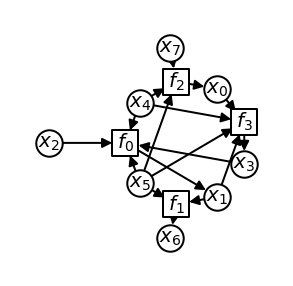

In [59]:
edges = all_edges(merge_edges(Ein,Rin), Eout, partial(transform_E, tfx=lambda x: Node(x, COMP), tvar=lambda x: Node(x, VAR)))
G = nx.DiGraph(edges)
var_names = [Node(var, VAR) for var in all_variables(Ein, Eout)]
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape=node_shapes, prog='circo', figsize=(5,5), latexlabels=False);